In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
def cm_plot(y_test, y_pred):

    cm = confusion_matrix(y_test, y_pred)
    # Normalise
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(cmn, cmap='Blues', annot=True, fmt='.2f')
    sns.set(font_scale=1.3)
    plt.title("Confusion Matrix")

    return plt.show()

In [197]:
X = np.load("/kaggle/input/neymark-tsc/train_x.npy")
y = np.load("/kaggle/input/neymark-tsc/train_y.npy")
X_test_real = np.load("/kaggle/input/neymark-tsc/test_x.npy")

In [5]:
X_train.shape

(14667, 187)

In [6]:
X_test_real.shape

(7225, 187)

In [7]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 32.9 MB/s eta 0:00:0000:0100:01


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

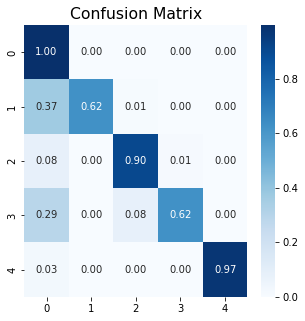

In [11]:
from sktime.classification.kernel_based import RocketClassifier

rocket = RocketClassifier(num_kernels=2500)

rocket.fit(X_train, y_train)
predictions = rocket.predict(X_val)

cm_plot(y_val, predictions)

In [14]:
from sklearn.metrics import f1_score, accuracy_score

In [16]:
f1_score(y_val, predictions, average="macro")

0.871024990907632

In [18]:
accuracy_score(y_val, predictions)

0.977050670302204

In [19]:
y_pred = rocket.predict(X_test_real)

score = 0.86421

In [20]:
# y_pred_csv = pd.DataFrame(list(range(len(y_pred))), columns=["Id"])
y_pred_csv = pd.DataFrame()
y_pred_csv["ID"] = np.array(range(len(y_pred))).astype(int).astype(str)
y_pred_csv["Answer"] = np.array(y_pred).astype(int).astype(str)
y_pred_csv.to_csv("testing_submission.csv", index=False)
y_pred_csv

,ID,Answer
0,0,0
1,1,0
2,2,0
3,3,2
4,4,0
...,...,...
7220,7220,0
7221,7221,2
7222,7222,0
7223,7223,0


In [22]:
rocket = RocketClassifier(num_kernels=2500, random_state=1)

rocket.fit(X, y)
y_pred = rocket.predict(X_test_real)

score = 0.85973

In [23]:
# y_pred_csv = pd.DataFrame(list(range(len(y_pred))), columns=["Id"])
y_pred_csv = pd.DataFrame()
y_pred_csv["ID"] = np.array(range(len(y_pred))).astype(int).astype(str)
y_pred_csv["Answer"] = np.array(y_pred).astype(int).astype(str)
y_pred_csv.to_csv("testing_submission.csv", index=False)
y_pred_csv

,ID,Answer
0,0,0
1,1,0
2,2,0
3,3,2
4,4,0
...,...,...
7220,7220,0
7221,7221,2
7222,7222,0
7223,7223,0


In [24]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import StepLR

from copy import deepcopy

In [199]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=1)
X_res, y_res = sm.fit_resample(X, y)

In [203]:
unique, counts = np.unique(y_res, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {counts}')

unique values: [0. 1. 2. 3. 4.]
counts: [12102 12102 12102 12102 12102]


In [204]:
y_res = y_res.reshape(-1, 1)
y_res.shape

(60510, 1)

In [205]:
X_res = X_res.reshape(-1, 1, 187)
X_res.shape

(60510, 1, 187)

In [206]:
X_mean = X_res.mean()
X_std = X_res.std()

X_ss = (X_res - X_mean) / X_std
X_ss.shape

(60510, 1, 187)

Text(0, 0.5, 'Амплитуда')

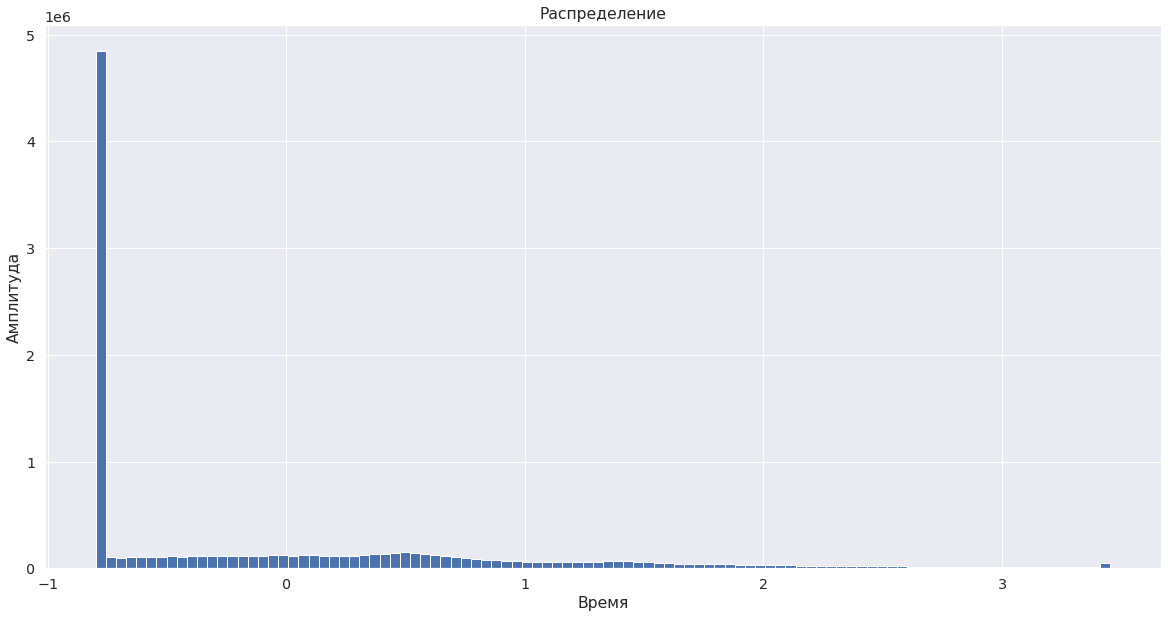

In [207]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.hist(X_ss.flatten(), bins=100)
ax.set_title(f'Распределение')
ax.set_xlabel('Время')
ax.set_ylabel('Амплитуда')

In [208]:
y_res = y_res.astype('int')
y_res.dtype

dtype('int64')

In [261]:
X_train, X_val, y_train, y_val = train_test_split(X_ss, y_res, 
                                                  test_size=0.2, 
                                                  shuffle=True)

In [262]:
unique, counts = np.unique(y_val, return_counts=True)
print(f'unique values: {unique}')
print(f'counts: {counts}')

unique values: [0 1 2 3 4]
counts: [2458 2447 2395 2366 2436]


In [281]:
hyper_params = {'batch_size': 1024,
                'lr'        : 1e-3,
                'lr_decay'  : 0.3,
                'epochs'    : 60 }

train = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(), 
                                          torch.from_numpy(y_train).long())
val = torch.utils.data.TensorDataset(torch.from_numpy(X_val).float(), 
                                        torch.from_numpy(y_val).long())

In [264]:
len(train), len(val)

(48408, 12102)

In [282]:
class_dist = np.unique(y_train, return_counts=True)[1] 
class_dist = class_dist/np.sum(class_dist)

weights = 1/class_dist
weights = weights/weights.sum()
weights

array([0.20077721, 0.20054846, 0.19947413, 0.19887997, 0.20032023])

In [152]:
y_train.shape

(11733, 1)

In [283]:
data_weights = np.zeros(y_train.shape[0])

for i in range(y_train.shape[0]):
    data_weights[i] = weights[y_train[i, 0]]
data_weights[:10]

array([0.20054846, 0.20054846, 0.19887997, 0.19947413, 0.20054846,
       0.20054846, 0.20077721, 0.19947413, 0.20077721, 0.19947413])

In [284]:
train_dl = DataLoader(train, batch_size=hyper_params['batch_size'], 
                      sampler=WeightedRandomSampler(weights=data_weights, 
                                                    num_samples=len(y_train), 
                                                    replacement=True))
val_dl = DataLoader(val, batch_size=hyper_params['batch_size'])

In [268]:
def model():
    return nn.Sequential(
        nn.Conv1d(1, 64, 11, 4, 0),
        nn.BatchNorm1d(64),
        nn.GELU(),
        nn.Conv1d(64, 64, kernel_size=1), nn.GELU(),
        nn.Conv1d(64, 64, kernel_size=1), nn.GELU(),
        nn.MaxPool1d(3, stride=2),
        
        nn.Conv1d(64, 128, 5, 1, 2),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Conv1d(128, 128, kernel_size=1), nn.GELU(),
        nn.Conv1d(128, 128, kernel_size=1), nn.GELU(), 
        nn.MaxPool1d(3, stride=2),
        
        nn.Conv1d(128, 64, 3, 1, 1),
        nn.BatchNorm1d(64),
        nn.GELU(),
        nn.Conv1d(64, 64, kernel_size=1), nn.GELU(),
        nn.Conv1d(64, 64, kernel_size=1), nn.GELU(),
        nn.Dropout(0.4), 
        
        nn.Conv1d(64, 5, 3, 1, 1),
        nn.BatchNorm1d(5),
        nn.GELU(),
        nn.Conv1d(5, 5, kernel_size=1), nn.GELU(),
        nn.Conv1d(5, 5, kernel_size=1), nn.GELU(),
        
        nn.AdaptiveAvgPool1d(1),
        nn.Flatten()
    )

In [285]:
cnn_model = model()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cnn_model = cnn_model.to(device)

cpu


In [286]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 1.1, 2.5, 3, 1], 
                                                    dtype=torch.float, 
                                                    device=device)) 

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=hyper_params['lr'])

lr_scheduler = StepLR(optimizer, step_size=10, 
                      gamma=hyper_params['lr_decay'], verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [287]:
def train(model, criterion, optimizer, train_dl, val_dl, epochs, lr_scheduler: StepLR=None):
    
    train_losses = []
    val_losses = []
    
    best_model_params = deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}\n',
              f'{"--------------------"}')
        train_loss = 0
        val_loss = 0
        model.train()
        
        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()
            output = model(x) 
            
            loss = criterion(output, y.squeeze())
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()*x.size(0)
            
        train_loss = train_loss/len(train_dl.dataset)
        train_losses.append(train_loss)
        lr_scheduler.step() 
        model.eval() 
        corrects = 0 
        
        for x, y in val_dl:
            x = x.to(device)
            y = y.to(device)
            output = model(x)
            loss = criterion(output, y.squeeze())
            val_loss += loss.item()*x.size(0)
            
            corrects += torch.sum(torch.argmax(output, dim=1) == y.squeeze()).item()
        
        val_loss = val_loss/len(val_dl.dataset)
        accuracy = corrects/len(val_dl.dataset)
        val_losses.append(val_loss)
        print(f'Train Loss: {train_loss:.4f} \t Val Loss: {val_loss:.4f} \t Val Accuracy: {accuracy:.4f}\n')
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_params = deepcopy(model.state_dict())
            
    print('Finished Training and the best accuracy is: {:.4f}'.format(best_accuracy))
    return train_losses, val_losses, best_model_params, best_accuracy

In [234]:
train_losses, val_losses, best_model_params, best_accuracy = train(cnn_model, 
                                         criterion, 
                                         optimizer, 
                                         train_dl, 
                                         val_dl, 
                                         hyper_params['epochs'], 
                                         lr_scheduler)

Epoch 1/60
 --------------------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.5256 	 Val Loss: 1.5866 	 Val Accuracy: 0.3304

Epoch 2/60
 --------------------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.3620 	 Val Loss: 1.3490 	 Val Accuracy: 0.5687

Epoch 3/60
 --------------------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 1.1648 	 Val Loss: 1.0986 	 Val Accuracy: 0.5901

Epoch 4/60
 --------------------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.9937 	 Val Loss: 0.9297 	 Val Accuracy: 0.5973

Epoch 5/60
 --------------------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.8099 	 Val Loss: 0.7527 	 Val Accuracy: 0.7113

Epoch 6/60
 --------------------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.6011 	 Val Loss: 0.5649 	 Val Accuracy: 0.7809

Epoch 7/60
 --------------------
Adjusting learning rate of group 0 to 1.0000e-03.
Train Loss: 0.4677 	 Val Loss: 0.4597 	 Val Acc

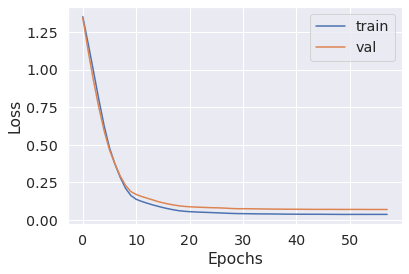

In [235]:
plt.plot(np.convolve(train_losses, np.ones(3)/3, mode='valid'), label='train')
plt.plot(np.convolve(val_losses, np.ones(3)/3, mode='valid'), label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [289]:
cnn_model.load_state_dict(best_model_params)
torch.save(cnn_model.state_dict(), f'best_model{best_accuracy:.2f}.pt')

In [237]:
y_pred = []
for x, y in val_dl:
    x = x.to(device)
    y = y.to(device)
    output = cnn_model(x) 
    y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())

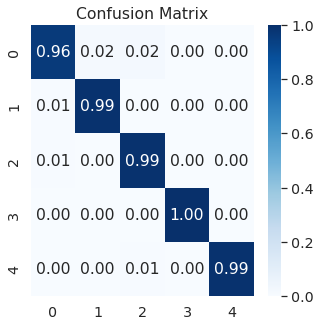

In [238]:
cm_plot(y_val, y_pred)

In [239]:
X_test_real.shape

(7225, 187)

In [290]:
X_test = np.reshape(X_test_real, (X_test_real.shape[0], 1, X_test_real.shape[1]))
X_test.shape

(7225, 1, 187)

In [291]:
X_test = (X_test - X_test.mean())/X_test.std()

In [292]:
test_ds = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float())
test_dl = DataLoader(test_ds, batch_size=hyper_params['batch_size'], shuffle=False)

In [293]:
y_pred = []
for x in test_dl:
    x = x[0].to(device)
    output = cnn_model(x) 
    y_pred.extend(torch.argmax(output, dim=1).cpu().numpy())

In [294]:
pred = y_pred.copy()
y_pred = np.array(y_pred)

In [295]:
y_pred_csv = pd.DataFrame()
y_pred_csv["ID"] = np.array(range(len(y_pred))).astype(int).astype(str)
y_pred_csv["Answer"] = np.array(y_pred).astype(int).astype(str)
y_pred_csv.to_csv("testing_submission.csv", index=False)
y_pred_csv

,ID,Answer
0,0,1
1,1,1
2,2,1
3,3,2
4,4,1
...,...,...
7220,7220,1
7221,7221,2
7222,7222,1
7223,7223,1


score = 0.8

In [3]:
X = np.load("train_x.npy")
y = np.load("train_y.npy")
X_test_real = np.load("test_x.npy")

In [4]:
X = pd.DataFrame(X)
y = pd.DataFrame(y, columns=['class'])

X_test_real = pd.DataFrame(X_test_real)

In [5]:
from imblearn.over_sampling import RandomOverSampler

X_balanced, y_balanced = RandomOverSampler().fit_resample(X, y)

In [6]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=1)

/var/folders/94/hvx_67xd46x5khdml3kckt080000gn/T/ipykernel_65384/123547918.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


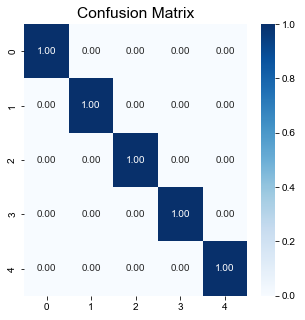

In [7]:
clf = ExtraTreesClassifier(n_estimators=200, random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

cm_plot(y_test, pred)

In [8]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

model = ExtraTreesClassifier(random_state=0)
kfold = KFold(n_splits=5, random_state=10, shuffle=True)

parameters = {
              'n_estimators'     : [200, 250, 300],
              'max_depth'        : [45, 50, 52, 55]
             }

model = GridSearchCV(model, parameters, scoring='accuracy', cv=kfold, n_jobs=-1)
model.fit(X_train, y_train)

model.best_score_, model.best_params_

/Users/annasidorova/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/annasidorova/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/annasidorova/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/annasidorova/opt/anaconda3/lib/python3.9/site-packages/sklearn/mod

(0.9994097732094691, {'max_depth': 50, 'n_estimators': 250})

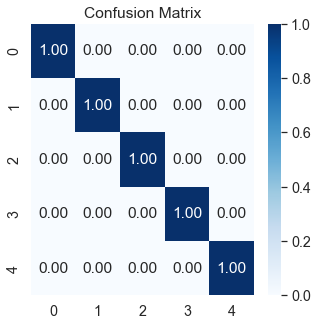

In [9]:
model = ExtraTreesClassifier(random_state=0, **model.best_params_)

model.fit(X_train, y_train)
pred = model.predict(X_test)

cm_plot(y_test, pred)

In [11]:
y_pred = model.predict(X_test_real)

In [12]:
y_pred_csv = pd.DataFrame()
y_pred_csv["ID"] = np.array(range(len(y_pred))).astype(int).astype(str)
y_pred_csv["Answer"] = np.array(y_pred).astype(int).astype(str)
y_pred_csv.to_csv("testing_submission.csv", index=False)
y_pred_csv

,ID,Answer
0,0,0
1,1,0
2,2,0
3,3,2
4,4,0
...,...,...
7220,7220,0
7221,7221,2
7222,7222,0
7223,7223,0
